In [33]:
import numpy as np
import pandas as pd

In [34]:
df = pd.read_csv('../data/rating_explicit_only.csv', sep=',', skipinitialspace=True)

n_users = df.learner_id.unique().shape[0]
n_items = df.movie_id.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 78 | Number of movies = 405


In [35]:
id_max = df.sort_values(by=['learner_id'], ascending=False).head(n=1)

id_max = int(id_max.learner_id)

print('The maximum learner_id in this list is= ' + str(id_max))

The maximum learner_id in this list is= 111


In [36]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)


In [37]:
# Create training and test matrix
R = np.zeros((id_max, n_items))
for line in train_data.itertuples():
    R[line[6]-1, line[5]-1] = line[2]  

T = np.zeros((id_max, n_items))
for line in test_data.itertuples():
    T[line[6]-1, line[5]-1] = line[2]

In [38]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [39]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

In [92]:
lmbda = 0.5 # Regularisation weight
k = 8  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.005  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [93]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [94]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
        #print(P)
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    print("Epoch["+ str(epoch+1) + "/" + str(n_epochs) + "] Train error:" + str(train_rmse) + "-->Test error:" + str(test_rmse))

Epoch[1/100] Train error:2.78634925795-->Test error:3.12335847899
Epoch[2/100] Train error:1.94967163939-->Test error:2.28486851281
Epoch[3/100] Train error:1.67904533552-->Test error:2.0389710173
Epoch[4/100] Train error:1.53640061275-->Test error:1.91987085212
Epoch[5/100] Train error:1.44487209841-->Test error:1.84475148322
Epoch[6/100] Train error:1.38105055571-->Test error:1.79111834563
Epoch[7/100] Train error:1.33423072893-->Test error:1.7501201238
Epoch[8/100] Train error:1.29849949885-->Test error:1.71735663326
Epoch[9/100] Train error:1.27030496477-->Test error:1.69032692039
Epoch[10/100] Train error:1.24740852724-->Test error:1.66748627223
Epoch[11/100] Train error:1.22834800815-->Test error:1.64782322088
Epoch[12/100] Train error:1.21213895313-->Test error:1.63064490773
Epoch[13/100] Train error:1.1981003983-->Test error:1.61545886799
Epoch[14/100] Train error:1.18574968195-->Test error:1.60190395257
Epoch[15/100] Train error:1.17473706596-->Test error:1.58970806691
Epoch[1

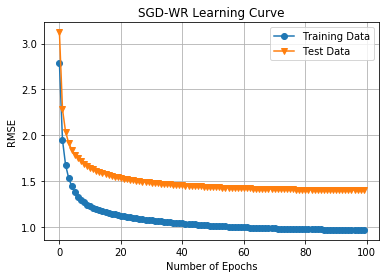

In [95]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [28]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [29]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[16,R.loc[16,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[16,R.loc[16,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
44,3.0,1.782544
49,5.0,3.620201
64,4.0,3.585750
80,3.0,2.585881
82,2.0,2.270561
